# Assignment 3. Coding 2 by [Rufaim](https://github.com/Rufaim)

---
Synchronous Advantage Actor Critic (A2C) algorithm (Mnih et al., 2016) with a two layered Neural Network.

Use the mountain car and CartPole environments from Open AI gym.
Set the discount factor $\gamma$ to 0.9.

Present your results in a plot showing on the $x$-axis should the episode count and on the $y$-axis the episode length (train until convergence).
Run on 5 different seeds.
The resultant plots will be averaged over these 5 independent seeds.
Also show the confidence interval (using the standard deviation).

#### References

1. Mnih, Volodymyr et al. (2016). “Asynchronous Methods for Deep Reinforcement Learning”. In: CoRR abs/1602.01783. arXiv: 1602.01783. url: http://arxiv.org/abs/1602.01783.

## Imports and Global constants

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    # limitting gpu memory to prevent tensorflow of
    # consuming all memory as it likes
    tf.config.set_logical_device_configuration(gpu,
    [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])

In [0]:
import numpy as np
import gym
import matplotlib.pyplot as pyplot

REGULARIZATION_RATE is a coefficient of entropy term of the loss.

UPDATE_PERIOD shows how many steps do we roll in the batch before run of an update step. 

---

Default parameters are:
```python
GAMMA = 0.9
REGULARIZATION_RATE = 1e-2
NUM_EPISODES = 10000
NUM_TRIALS = 20
UPDATE_PERIOD = 64
SEED = 42
```

In [0]:
GAMMA = 0.9
REGULARIZATION_RATE = 1e-2
NUM_EPISODES = 10000
NUM_TRIALS = 20
UPDATE_PERIOD = 64
SEED = 42

## Disclaimer

The following implementation is a Syncronious Advantage Actor Critic (A2C) mostly based on [A2C article](https://arxiv.org/pdf/1602.01783.pdf).

The implementation idiomatically follows keypoints of an OpenAI's [blogpost](https://openai.com/blog/baselines-acktr-a2c):
*   An updating scheme operates on fixed-length segments of experience and uses these segments to compute estimators of the returns and advantage function.
*   Neural network architecture shares layers between the policy and value function.

Hyperparameter choice (such for regularization rate, num episodes, etc.) are based on parameters provided in the [original article](https://arxiv.org/pdf/1602.01783.pdf) or [authors' implementation](https://github.com/openai/baselines/tree/master/baselines/a2c).


## Agent

### Policy Neural Network

The first thing that is required for implementation is a neural network itself.
As mentioned in [the blogpost](https://openai.com/blog/baselines-acktr-a2c) it shares parameters between policy and value functions. Therefore we have two layers that output some latent representation of a state and two layers outputting action distribution and value of the state respectively. 

In [0]:
class PolicyNetwork(tf.keras.Model):
    def __init__(self, state_space, action_space, sizes=(64, 64), seed=None):
        super(PolicyNetwork, self).__init__()
        init_w = tf.keras.initializers.GlorotUniform(seed)
        init_b = tf.keras.initializers.Zeros()
        self.dense_layer_1 = tf.keras.layers.Dense(sizes[0], activation=tf.nn.relu,
                                                       kernel_initializer=init_w, bias_initializer=init_b)
        self.dense_layer_2 = tf.keras.layers.Dense(sizes[1], activation=tf.nn.relu,
                                                       kernel_initializer=init_w, bias_initializer=init_b)
        self.pi_logit_layer = tf.keras.layers.Dense(action_space,
                                                    kernel_initializer=init_w, bias_initializer=init_b)
        self.value_f_layer = tf.keras.layers.Dense(1, kernel_initializer=init_w, bias_initializer=init_b)

    @tf.function
    def call(self, state):
        x = self.dense_layer_1(state)
        x = self.dense_layer_2(x)
        # Note: that pi_logit is not a distribution.
        #       to get a distribution you need to perform
        #       distribution = tf.nn.softmax(pi_logit,axis=-1)
        #       that was done for easier loss computation
        pi_logit = self.pi_logit_layer(x)
        value_f = self.value_f_layer(x)
        return pi_logit, value_f

### Entropy calculation

According to [article](https://arxiv.org/pdf/1602.01783.pdf) we require to calculate entropy of the policy in order to use it as a regularizer.

Entropy has a simple formula:
$$
H(x) = -\sum_{i=0}^{N} p(x_i) \log(p(x_i)),
$$
where $p(x_i) = \frac{\displaystyle\exp(x_i)}{\displaystyle\sum_{i=0}^{N}\exp(x_i)}$

In [0]:
@tf.function
def entropy_old(logits):
    # We will not use that implementation
    # this is an outdated implementation similar to one used in the original code
    # 
    # Tragically boxed with technologies of their time 
    # poor authors had to implement entropy calculations manually,
    # which to their credits was done greatly.
    l_i = logits - tf.reduce_max(logits, axis=-1, keepdims=True)
    exp_l_i = tf.exp(l_i)
    sum_exp_l_i = tf.reduce_sum(exp_l_i, axis=-1, keepdims=True)
    p_i = exp_l_i / sum_exp_l_i
    # this implementation is similar the formulas above, 
    # simplified with respect to a softmax
    return tf.reduce_sum(p_i * (tf.math.log(sum_exp_l_i) - l_i), axis=-1)

@tf.function
def entropy(logits):
    # Luckily, in our not_so_distant, but quite advanced future
    # where we have Tensorflow 2.0 and 
    # where our innovative science of the future
    # is able to produce such scientific miracles as androids, organic LEDs and,
    # of course, gradient flow through labels for the tf.nn.softmax_cross_entropy_with_logits
    # we, Beings of the Future, can replace previous outdated implementation with
    # just two simple functions and have the same training result.
    p_i = tf.nn.softmax(logits,axis=-1)
    return tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=p_i)

### Agent

Our agent based on policy network should be able to perform:
1. action sampling
1. weigths update
4. targets calculation for weigths update

**Action sampling** is simple, since for each state we have probabilities for actions outputted by policy network.

**Weigths are updated** according to loss:
$$
Loss =  Loss_{critic} + Loss_{actor} - Enropy
$$

$Loss_{critic}$ is classical TD L2 loss:
$$
Loss_{critic} = \frac{1}{N} \sum_{i=1}^{N} \left( G_i - V(s_i) \right)^2
$$

In $Loss_{actor}$ we are using advantages:
$$
Loss_{actor} = -\frac{1}{N} \sum_{i=1}^{N} A(s_i,a_i) \log(p(a_i))
$$
where $A(s_i,a_i) = G_i - V(s_i)$

Entropy was calculated in the previous subsection. By the way it is substracted because regularization technique is to maximize entropy.

Now we require only to calculate **targets** $G_i$ given batch of tuples ${(s_i,r_i,t_i)}_{i=[1..N]}$ and the last observed state $s_{N+1}$.
$$
G_i = r_i + \gamma G_{i+1} \mathbb{I}_{[t_i \neq 1]}
$$
where $G_{N+1} = V(s_{N+1})$


In [0]:
class A2CAgent(object):
    def __init__(self, network, action_size, learning_rate=5e-4, regularization_rate=0.01, gamma=0.99,
                 max_grad_norm=5, seed=None):
        tf.random.set_seed(seed)
        self.network = network
        self.action_size = action_size
        # Note that we are using Adam instead of RMSProp from the article
        # because adam supposed to better on the complex spaces.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.regularization_rate = tf.constant(regularization_rate, dtype=tf.float32)
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.max_grad_norm = tf.constant(max_grad_norm, dtype=tf.float32)

    def sample_action(self, state):
        actions, values = self._sample_action(np.atleast_2d(state.astype(np.float32)))
        return actions.numpy(), values.numpy()

    def get_values(self, state):
        _, values = self.network(np.atleast_2d(state.astype(np.float32)))
        return tf.squeeze(values).numpy()

    @tf.function
    def update(self, states, actions, rewards, terminates, last_state):
        _, last_value = self.network(last_state)
        rs = self._get_rewards(rewards, terminates, last_value)
        with tf.GradientTape() as g:
            logits, values = self.network(states)
            advs = tf.stop_gradient(rs - values)
            neglogpi = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
            pg_loss = tf.reduce_mean(advs * neglogpi)
            vf_loss = tf.reduce_mean((values - rs) ** 2)
            ent_ = tf.reduce_mean(entropy(logits))
            loss = pg_loss + vf_loss - self.regularization_rate * ent_

        grads = g.gradient(loss, self.network.trainable_variables)
        # we are also clipped gradients
        # yes, it slow down convergence a bit on the beginning, but
        # make it better on a long term
        grads, grad_norm = tf.clip_by_global_norm(grads, self.max_grad_norm)
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

    @tf.function
    def _get_rewards(self, rewards, terminates, last_value):
        reward_batch_size = tf.shape(rewards)[0]
        tms = tf.TensorArray(tf.float32, size=reward_batch_size)
        tms = tms.unstack(terminates)
        rws = tf.TensorArray(tf.float32, size=reward_batch_size)
        rws = rws.unstack(rewards)
        rs = tf.TensorArray(tf.float32, size=reward_batch_size)
        r = last_value
        for i in range(reward_batch_size):
            r = rws.read(reward_batch_size - i - 1) + self.gamma * r * (1. - tms.read(reward_batch_size - i - 1))
            rs = rs.write(reward_batch_size - i - 1, r)
        return rs.stack()

    @tf.function
    def _sample_action(self, state):
        logits, values = self.network(state)
        return tf.random.categorical(logits, 1), tf.squeeze(values)

## Test Framework

In following series of experimens we are measuring expected episode length.
We would like it to be as high as possible, keeping in mind that cumulative rewards are bounded with two hundrets units for CartPole.

In [0]:
# Saying that learning process is as slow as sloth 
# would be a huge insulting to speed of the all tropical sloths of the world
# Thus saving results is a good idea
def save(filename, episode_len):
    np.savez_compressed(filename,
                        episode_len=episode_len)

def load(filename):
    data = np.load(filename)
    return data["episode_len"]

In [0]:
class TestFramwork(object):
    def __init__(self,experiment_builder,num_trials,max_episodes,update_period,masterseed=None):
        self.experiment_builder = experiment_builder  #input: lr, seed
        self.num_trials = num_trials
        self.max_episodes = max_episodes
        self.update_period = update_period
        self.masterseed = masterseed
        self.reset()

    def reset(self):
        self._random_generator = np.random.RandomState(self.masterseed)
    
    def run_trial(self,env,agent):
        current_state = env.reset()
        current_ep = 0
        actions_batch = np.zeros((self.update_period,),dtype=np.int32)
        rewards_batch = np.zeros((self.update_period,1),dtype=np.float32)
        terminates_batch = np.zeros((self.update_period,1),dtype=np.float32)
        states_batch = np.zeros((self.update_period,current_state.shape[-1]),dtype=np.float32)

        episode_rewards = np.zeros((self.max_episodes,))
        while current_ep < self.max_episodes:
            for i in range(self.update_period):
                a, vals = agent.sample_action(current_state)
                a = int(a[0])
                s_, r, t, _ = env.step(a)
                if current_ep < self.max_episodes:
                    # if right now you have an intent to say "wait a minute we recorded rewards!"
                    # then recall that for CartPole enviroment cumulative rewards is equal to episode length
                    episode_rewards[current_ep] += r 
                if t:
                    current_ep += 1
                    s_ = env.reset()

                states_batch[i] = current_state.copy()
                actions_batch[i] = a
                rewards_batch[i] = r
                terminates_batch[i] = t

                current_state = s_

            agent.update(states_batch,actions_batch,rewards_batch,terminates_batch,np.atleast_2d(s_).astype(np.float32))

        return episode_rewards
    
    def run_experiment(self,learning_rate):
        seeds = self._random_generator.randint(0,1000000, size=self.num_trials)
        episode_rewards = np.zeros((self.num_trials, self.max_episodes,))

        for trial in range(self.num_trials):
            env, agent = self.experiment_builder(learning_rate,seeds[trial])
            print("\rTrial # {} of {}".format(trial+1,self.num_trials),end="")
            episode_rewards[trial,:] = self.run_trial(env,agent)
        print()
        return episode_rewards
        

## Experiments

In the current series of experimens we are measuring expected episode length.

From the [OpenAi baselines](https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/a2c/a2c.py#L34) (because it is omitted in the article) we can see that default learning rate is $7 \times 10^{-4}$. So, for the learning rate we are going to test a range around default value from $10^{-3}$ to $10^{-4}$ with three values (borders and the middle). To see how this parameter influences the performance.

### Setting up test framework

In [0]:
def experiment_builder(lr,seed):
    env = gym.make('CartPole-v0')
    env.seed(int(seed))
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    net = PolicyNetwork(state_size,action_size,sizes=(128,128),seed=seed)
    agent = A2CAgent(net,action_size,learning_rate=lr,regularization_rate=REGULARIZATION_RATE,gamma=GAMMA,seed=seed)
    return env, agent

In [0]:
test_framework = TestFramwork(experiment_builder,NUM_TRIALS,NUM_EPISODES,UPDATE_PERIOD,SEED)

### Run experiments


In [0]:
lrs = [1e-4,5e-4,1e-3]

In [0]:
results_lr1 = test_framework.run_experiment(lrs[0])
save(f"a2c_lr_{lrs[0]}_results.npz",results_lr1)

/home/pavel/New_programms/RL_Assignment_3/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Trial # 1 of 20

/home/pavel/New_programms/RL_Assignment_3/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Trial # 2 of 20Trial # 3 of 20Trial # 4 of 20Trial # 5 of 20Trial # 6 of 20Trial # 7 of 20Trial # 8 of 20Trial # 9 of 20Trial # 10 of 20Trial # 11 of 20Trial # 12 of 20Trial # 13 of 20Trial # 14 of 20Trial # 15 of 20Trial # 16 of 20Trial # 17 of 20Trial # 18 of 20Trial # 19 of 20Trial # 20 of 20


In [0]:
test_framework.reset()
results_lr2 = test_framework.run_experiment(lrs[1])
save(f"a2c_lr_{lrs[1]}_results.npz",results_lr2)

Trial # 1 of 20Trial # 2 of 20Trial # 3 of 20Trial # 4 of 20Trial # 5 of 20Trial # 6 of 20Trial # 7 of 20Trial # 8 of 20Trial # 9 of 20Trial # 10 of 20Trial # 11 of 20Trial # 12 of 20Trial # 13 of 20Trial # 14 of 20Trial # 15 of 20Trial # 16 of 20Trial # 17 of 20Trial # 18 of 20Trial # 19 of 20Trial # 20 of 20


In [0]:
test_framework.reset()
results_lr3 = test_framework.run_experiment(lrs[2])
save(f"a2c_lr_{lrs[2]}_results.npz",results_lr3)

Trial # 1 of 20Trial # 2 of 20Trial # 3 of 20Trial # 4 of 20Trial # 5 of 20Trial # 6 of 20Trial # 7 of 20Trial # 8 of 20Trial # 9 of 20Trial # 10 of 20Trial # 11 of 20Trial # 12 of 20Trial # 13 of 20Trial # 14 of 20Trial # 15 of 20Trial # 16 of 20Trial # 17 of 20Trial # 18 of 20Trial # 19 of 20Trial # 20 of 20


## Results

In [0]:
results_lr1 = load(f"a2c_lr_{lrs[0]}_results.npz")
results_lr2 = load(f"a2c_lr_{lrs[1]}_results.npz")
results_lr3 = load(f"a2c_lr_{lrs[2]}_results.npz")

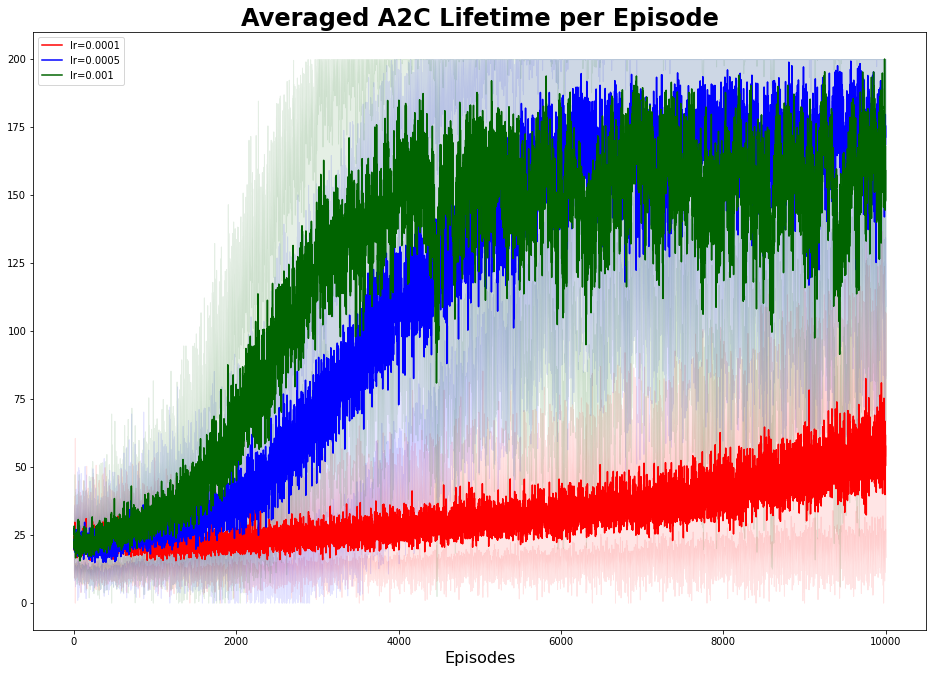

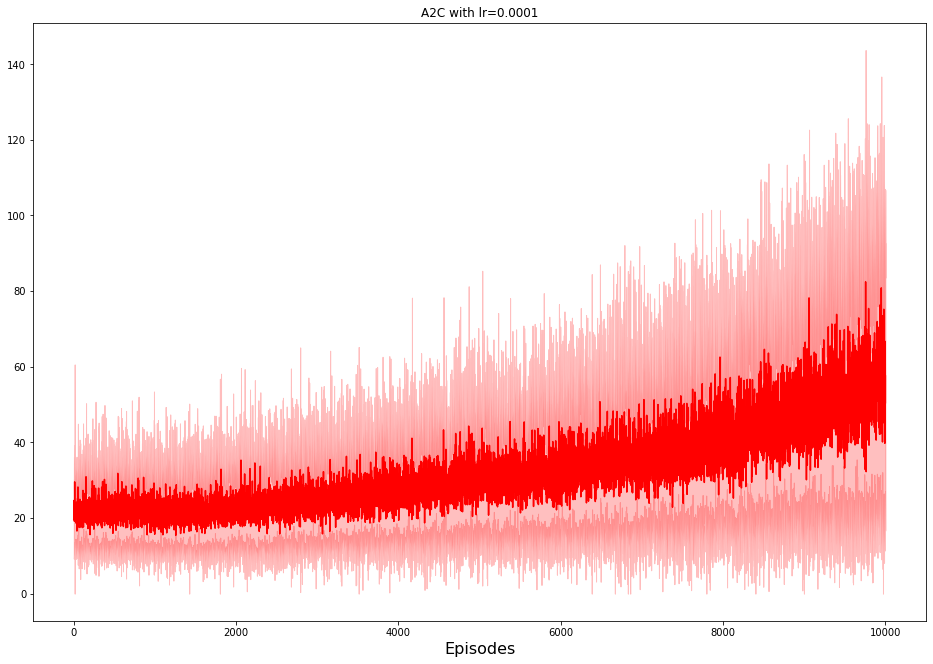

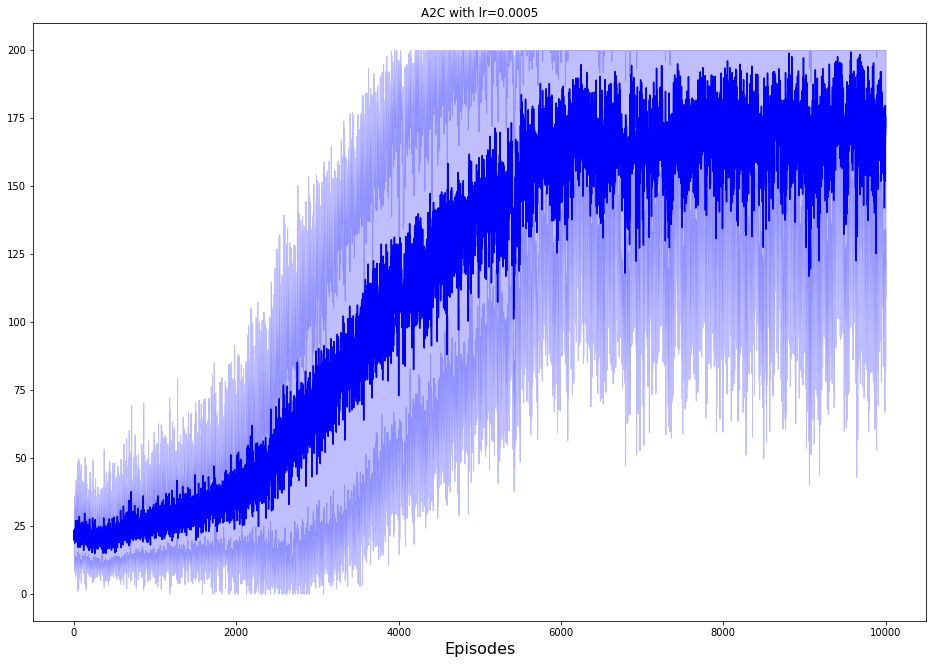

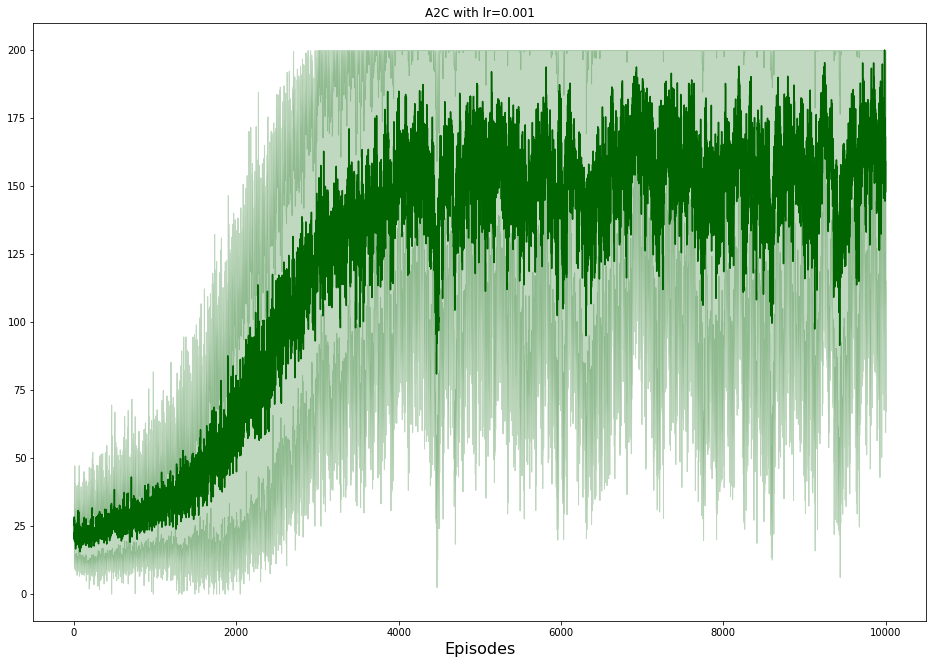

In [0]:
colors_ = ["red","blue","darkgreen"]
# why darkgreen? Obviously, because it is greener than a plain green
fig, ax = pyplot.subplots(figsize=(16,11))
ax.set_xlabel("Episodes", fontsize=16)
ax.set_title("Averaged A2C Lifetime per Episode", fontsize=24, fontweight="bold")

for res, lr,c in zip([results_lr1,results_lr2,results_lr3],lrs,colors_):
    episodes = np.arange(res.shape[1])
    r = np.mean(res,axis=0)
    r_std = np.std(res,axis=0)
    std_plus = np.minimum(r + r_std,200)
    std_minus = np.maximum(r - r_std,0)
    ax.plot(episodes,r,c=c,label=f"lr={lr}")
    ax.fill_between(episodes, std_minus, std_plus, color=c, alpha=0.1)

    pyplot.subplots(figsize=(16,11))
    pyplot.plot(r,c=c)
    pyplot.fill_between(episodes, std_minus, std_plus, color=c, alpha=0.25)
    pyplot.xlabel("Episodes", fontsize=16)
    pyplot.title(f"A2C with lr={lr}")

# if it is hard for you to understand plots, it is fune.
# Same for me, since they are to noisy. 
# Look at the effect on the edges of the trust regions! Nice looking, isn't?
ax.legend(loc="best")

The following results are the same, but smoothed with moving average.
Smoothing shall reduce noise of the expected result and their confidence interval.

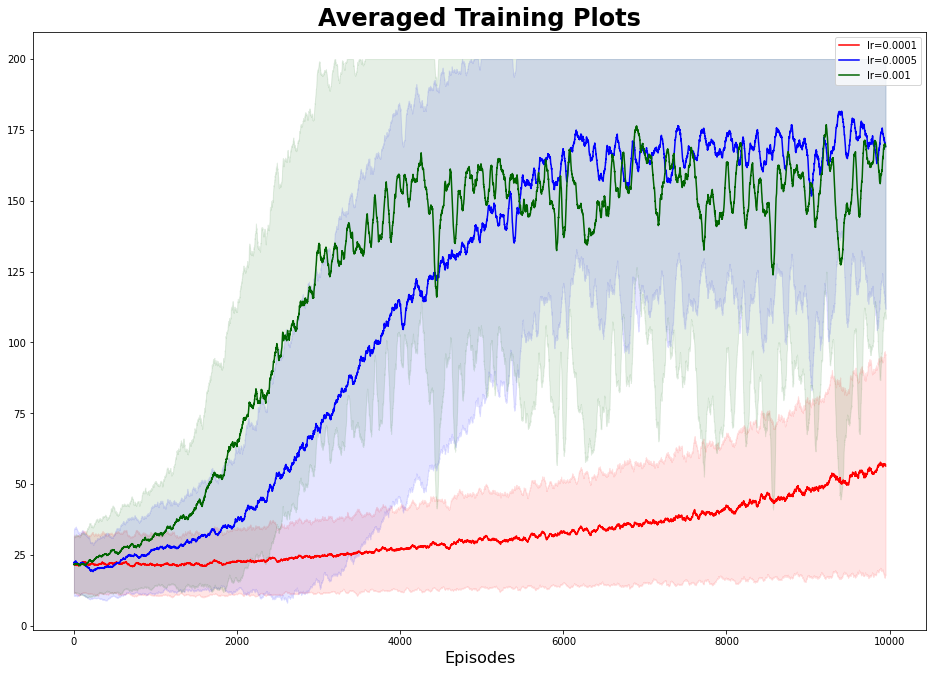

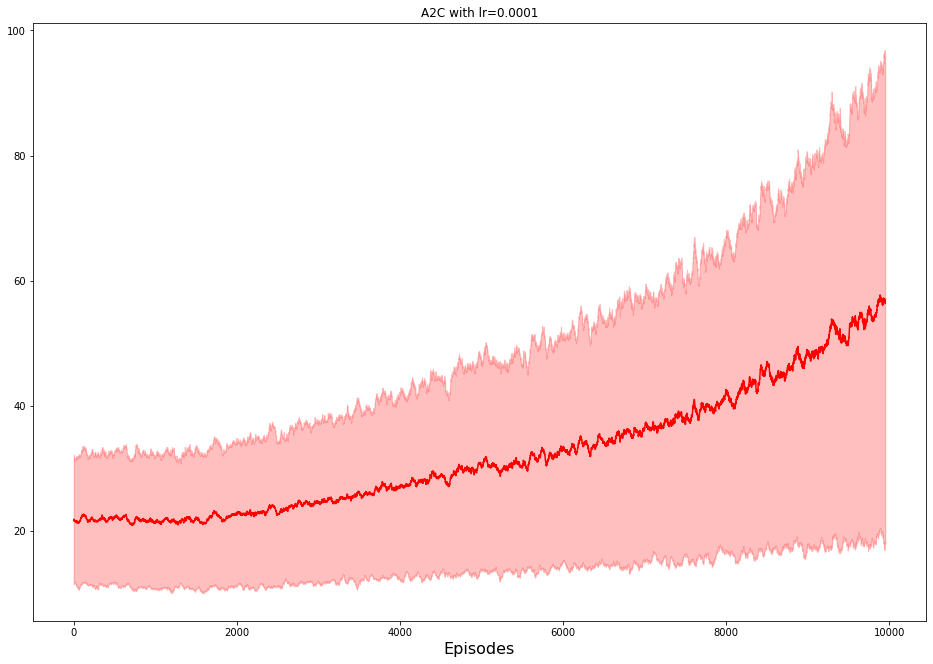

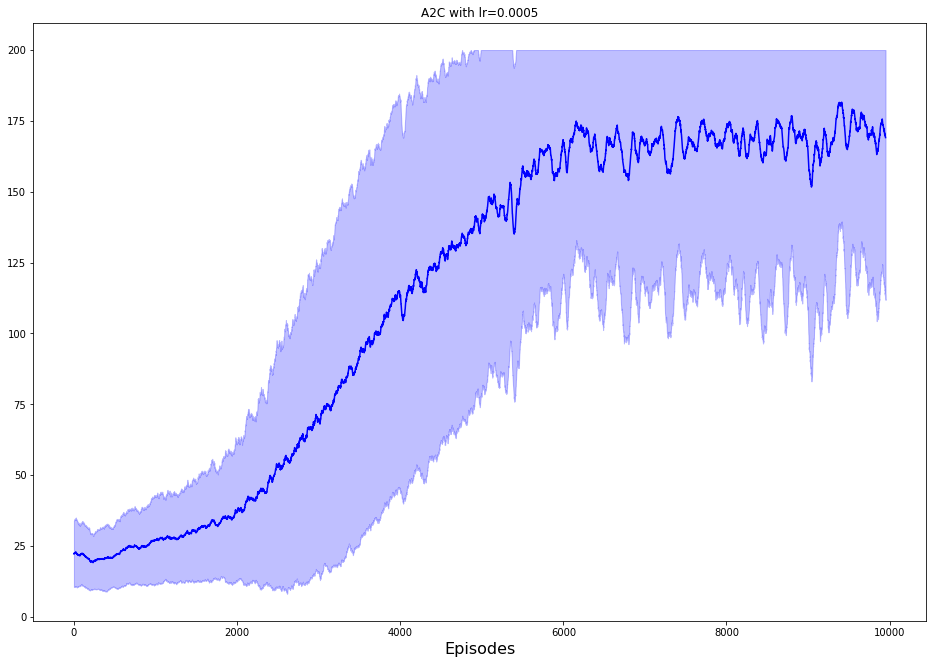

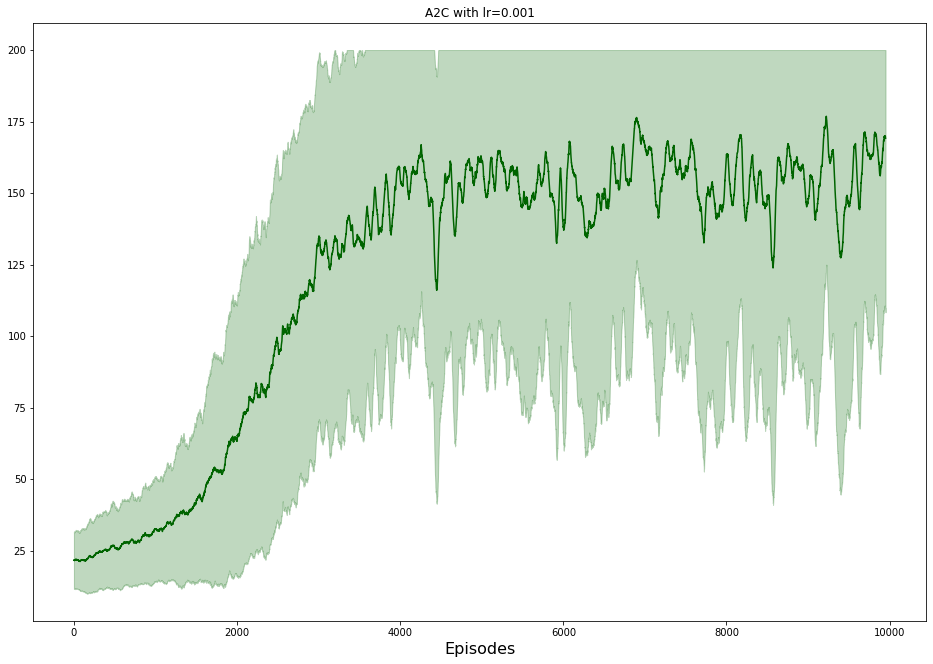

In [0]:
mov_avg = 50 # Window averaging will save tha day!
colors_ = ["red","blue","darkgreen"]
fig, ax = pyplot.subplots(figsize=(16,11))
ax.set_xlabel("Episodes", fontsize=16)
ax.set_title("Averaged Training Plots", fontsize=24, fontweight="bold")

for res, lr,c in zip([results_lr1,results_lr2,results_lr3],lrs,colors_):
    weights = np.ones(mov_avg) / mov_avg
    r = np.mean(res,axis=0)
    r = np.convolve(r, weights, mode='valid')
    r_std = np.std(res,axis=0)
    r_std = np.convolve(r_std, weights, mode='valid')
    episodes = np.arange(r_std.shape[0])
    std_plus = np.minimum(r + r_std,200)
    std_minus = np.maximum(r - r_std,0)
    ax.plot(episodes,r,c=c,label=f"lr={lr}")
    ax.fill_between(episodes, std_minus, std_plus, color=c, alpha=0.1)

    pyplot.subplots(figsize=(16,11))
    pyplot.plot(r,c=c)
    pyplot.fill_between(episodes, std_minus, std_plus, color=c, alpha=0.25)
    pyplot.xlabel("Episodes", fontsize=16)
    pyplot.title(f"A2C with lr={lr}")

# much better! At least, trust regions now look like solid regions. 
ax.legend(loc="best")

As it could be clearly seen results are very noisy. Even averaged over twnty runs with differend seeds we have quite big confidence interval.

Regarding learning rate we can see that empirical rule "smaller, but not too small" are still appliable here. However suitable learning rate is smaller than learning rate for a supervised task, which usually choosen in range from $10^{-2}$ to $10^{-3}$, while A2C range is from from $10^{-3}$ to $10^{-4}$, where $10^{-4}$ converges too slow and $10^{-3}$ in slightly unstable.

Interesting observation, that smoothed trainig curve for learning rate of $5 \times 10^{-4}$ still has upper trend, so it seems to be possible to achive higher performance continuing trainig.